<a href="https://colab.research.google.com/github/jiwoncpark/cs330-deep-multitask-meta-learning/blob/master/hw/hw1/CS330_Homework1_Stencil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Need to download the Omniglot dataset -- DON'T MODIFY THIS CELL
if not os.path.isdir('./omniglot_resized'):
    gdd.download_file_from_google_drive(file_id='1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI',
                                        dest_path='./omniglot_resized.zip',
                                        unzip=True)
    
assert os.path.isdir('./omniglot_resized')

In [2]:
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc


def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        # Draw K random samples (images) from each character class
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))] # choose nb_samples images from character folder path
    if shuffle:
        # Permute order of tuples, maintaining each tuple pairing
        random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    import imageio
    image = imageio.imread(filename)  # misc.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image


class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        # List of length 1623 (for 1623 characters)
        # Each element is a path nested with language (family),
        # e.g. ./omniglot_resized/Braille/character23
        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        folders = np.array(folders)
        # Initialize image and label arrays to output
        all_image_batches = np.empty([batch_size, self.num_samples_per_class, self.num_classes, self.dim_input])
        all_label_batches = np.empty([batch_size, self.num_samples_per_class, self.num_classes, self.num_classes])
        for b in range(batch_size):
          # Sample K images in N classes from the correct folder
          sampled_class_folders = folders[random.sample(range(len(folders)), self.num_classes)] # folders of sampled N classes for this batch
          labels = np.arange(self.num_classes) # arbitrary integer labels for the N classes
          labels_images = get_images(sampled_class_folders, labels, nb_samples=self.num_samples_per_class, shuffle=False) # list of length N*K
          for i, (label, img_path) in enumerate(labels_images):
            k = i%self.num_samples_per_class # index for image in given batch and class
            # Populate image
            img = image_file_to_array(img_path, self.dim_input).flatten()
            all_image_batches[b, k, label, :] = img
            # Populate one-hot label
            one_hot = np.eye(self.num_classes)[label]
            all_label_batches[b, k, label, :] = one_hot
        # Shuffle images and labels of last N examples (query examples) for each batch
        indices_along_N = np.arange(self.num_classes)
        np.random.shuffle(indices_along_N)
        all_image_batches[:, -1, :, :] = all_image_batches[:, -1, indices_along_N, :]
        all_label_batches[:, -1, :, :] = all_label_batches[:, -1, indices_along_N, :]
        #############################

        return all_image_batches.astype(np.float32), all_label_batches.astype(np.float32)


Images batch shape: (1, 4, 3, 784)
image label
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Labels batch shape: (1, 4, 3, 3)
[[[[1. 0. 0.]
   [0. 1. 0.]
   [0. 0. 1.]]

  [[1. 0. 0.]
   [0. 1. 0.]
   [0. 0. 1.]]

  [[1. 0. 0.]
   [0. 1. 0.]
   [0. 0. 1.]]

  [[0. 1. 0.]
   [0. 0. 1.]
   [1. 0. 0.]]]]


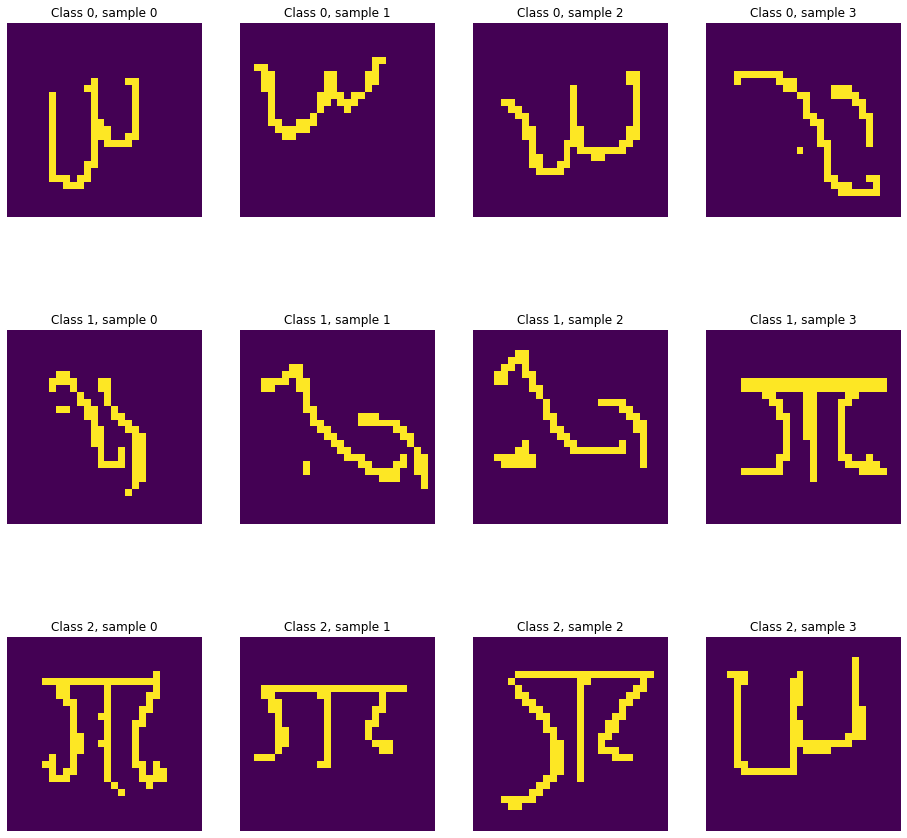

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

N = 3
K = 4
data_gen = DataGenerator(num_classes=N, num_samples_per_class=K)
images, labels = data_gen.sample_batch('train', batch_size=1)
print("Images batch shape:", images.shape)
print("image label")
print(images[:, :, :, 0])
print("Labels batch shape:", labels.shape)
print(labels)
plt.figure(figsize=(16, 16))
count = 0
for n in range(N):
    for k in range(K):
        plt.subplot(N, K, count + 1)
        plt.title("Class {:d}, sample {:d}".format(n, k))
        img = images[0, k, n].reshape((28, 28))
        plt.imshow(img)
        plt.axis('off');
        count += 1
plt.show()

In [4]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers

# Memory-augmented neural network
class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class, hidden_size=128):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class # K+1, not just K
        self.layer1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels: [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        batch_size, _, _, pix_dim = input_images.shape
        # Replace query labels with 0
        support_labels = tf.unstack(input_labels, axis=1)[:-1] # list of length K+1
        all_zeros_query_label = tf.zeros((batch_size, self.num_classes, self.num_classes)) # [B, N, N]
        updated_input_labels = tf.stack(support_labels + [all_zeros_query_label], axis=1) # [B, K+1, N, N]
        # Concat meta-training support with query
        concat_input = tf.concat([input_images, updated_input_labels], axis=-1) # [B, K+1, N, N+784]
        # Merge axes 1, 2
        concat_input = tf.reshape(concat_input, [batch_size, -1, pix_dim + self.num_classes]) # [B, (K+1)N, N+784]
        hidden = self.layer1(concat_input) # [B, K+1, hidden_size]
        out = self.layer2(hidden) # [B, (K+1)N, N]
        # Separate back axes 1, 2
        out = tf.reshape(out, [batch_size, self.samples_per_class, self.num_classes, self.num_classes]) # [B, K+1, N, N]
        #############################
        return out

    def loss_function(self, preds, labels):
        """
        Computes MANN loss
        Args:
            preds: [B, K+1, N, N] network output
            labels: [B, K+1, N, N] labels
        Returns:
            scalar loss
        """
        #############################
        #### YOUR CODE GOES HERE ####
        query_labels = labels[:, -1, :, :] 
        query_preds = preds[:, -1, :, :]
        loss = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, preds, axis=-1)) # also tf.keras.categorical_crossentropy
        return loss
        #############################


@tf.function
def train_step(images, labels, model, optim, eval=False):
    with tf.GradientTape() as tape:
        predictions = model(images, labels)
        loss = model.loss_function(predictions, labels)
    if not eval:
        gradients = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions, loss


def main(num_classes=5, num_samples=1, meta_batch_size=16, hidden_size=128, random_seed=1234):
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data_generator = DataGenerator(num_classes, num_samples + 1)

    o = MANN(num_classes, num_samples + 1, hidden_size=hidden_size)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)

    test_loss_every100 = []
    test_acc_every100 = []
    for step in range(25000):
        i, l = data_generator.sample_batch('train', meta_batch_size)
        _, ls = train_step(i, l, o, optim)

        if (step + 1) % 100 == 0:
            #print("*" * 5 + "Iter " + str(step + 1) + "*" * 5)
            i, l = data_generator.sample_batch('test', 100)
            pred, tls = train_step(i, l, o, optim, eval=True)
            #print("Train Loss:", ls.numpy(), "Test Loss:", tls.numpy())
            pred = tf.reshape(pred, [-1, num_samples + 1, num_classes, num_classes])
            pred = tf.math.argmax(pred[:, -1, :, :], axis=2)
            l = tf.math.argmax(l[:, -1, :, :], axis=2)
            test_acc = tf.reduce_mean(tf.cast(tf.math.equal(pred, l), tf.float32)).numpy()
            #print("Test Accuracy", test_acc)
            test_loss_every100.append(tls.numpy())
            test_acc_every100.append(test_acc)
    return test_loss_every100, test_acc_every100

0.0
[1. 0. 0.]


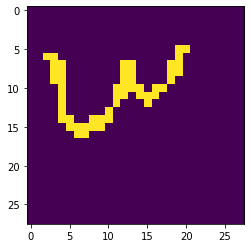

0.0
[0. 0. 1.]


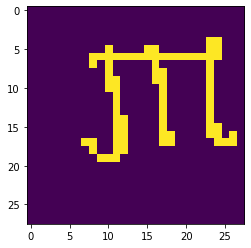

0.0
[0. 1. 0.]


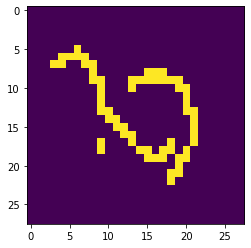

In [5]:
# Visually confirming for N=3, K=1+1
# One-hot labels should deviate from the ordering [1, 0, 0], [0, 1, 0], [0, 0, 1]
data_generator = DataGenerator(3, 1 + 1)
i, l = data_generator.sample_batch('train', 1) # batch of 1
for query_i in range(3): 
  plt.imshow(i[0, -1, query_i, :].reshape(28, 28))
  print(i[0, -1, query_i, 0])
  print(l[0, -1, query_i, :])
  plt.show()

0.0
[1. 0. 0.]


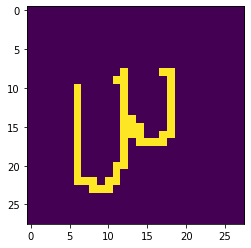

0.0
[0. 1. 0.]


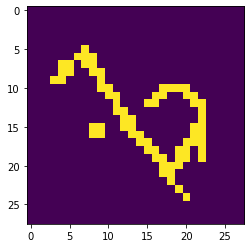

0.0
[0. 0. 1.]


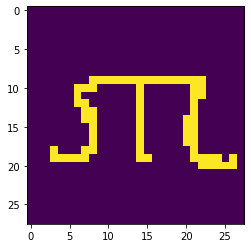

In [6]:
# Similarly, visualize support set
# One-hot labels should NOT deviate from the ordering [1, 0, 0], [0, 1, 0], [0, 0, 1]
# Label definition for each image should not differ ("w" should still be [1, 0, 0], etc.).
for support_i in range(3): 
  plt.imshow(i[0, 0, support_i, :].reshape(28, 28))
  print(i[0, 0, support_i, 0])
  print(l[0, 0, support_i, :])
  plt.show()

In [7]:
#results = main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234)

#3. Vary $K, N$.

In [ ]:
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)
#results = main(num_classes=5, num_samples=1, meta_batch_size=16, random_seed=1234)
#############################
#### YOUR CODE GOES HERE ####
test_loss_dict = {}
test_acc_dict = {}
K_N_grid = [(1, 2), (1, 3), (1, 4), (5, 4)]
for K, N in K_N_grid:
  print("K: {:d}, N: {:d}".format(K, N))
  test_loss, test_acc = main(num_classes=N, num_samples=K, meta_batch_size=16, random_seed=1234)
  test_loss_dict[(K, N)] = test_loss
  test_acc_dict[(K, N)] = test_acc
#############################

In [10]:
np.save('prob3_test_acc_dict.npy', test_acc_dict)
np.save('prob3_test_loss_dict.npy', test_loss_dict)

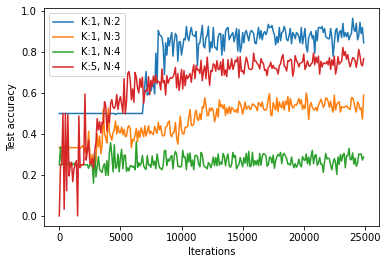

In [12]:
for conf, acc in test_acc_dict.items():
  iter_grid = np.arange(0, 25000, 100)
  K, N = conf
  plt.plot(iter_grid, acc, label='K:{:d}, N:{:d}'.format(K, N))
plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Iterations')
plt.savefig('prob3_vary_K_N_acc.png')

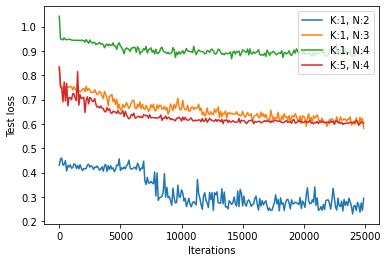

In [14]:
for conf, loss in test_loss_dict.items():
  iter_grid = np.arange(0, 25000, 100)
  K, N = conf
  plt.plot(iter_grid, loss, label='K:{:d}, N:{:d}'.format(K, N))
plt.legend()
plt.ylabel('Test loss')
plt.xlabel('Iterations')
plt.savefig('prob3_vary_K_N_loss.png')

#4. Vary hidden state size

In [8]:
tf.config.run_functions_eagerly(True)
test_loss_dict_hidden = {}
test_acc_dict_hidden = {}

for h in [64, 128, 256, 512]:
  print("hidden state size: {:d}".format(h))
  test_loss, test_acc = main(num_classes=3, num_samples=1, meta_batch_size=16, hidden_size=h, random_seed=1234)
  test_loss_dict_hidden[h] = test_loss
  test_acc_dict_hidden[h] = test_acc

hidden state size: 64
hidden state size: 128
hidden state size: 256
hidden state size: 512


In [9]:
np.save('prob4_test_acc_dict.npy', test_acc_dict_hidden)
np.save('prob4_test_loss_dict.npy', test_loss_dict_hidden)

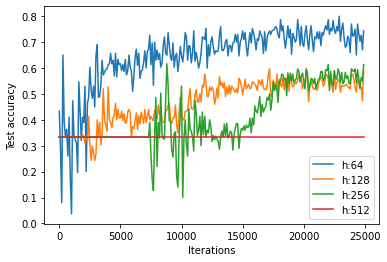

In [15]:
for h, acc in test_acc_dict_hidden.items():
  iter_grid = np.arange(0, 25000, 100)
  plt.plot(iter_grid, acc, label='h:{:d}'.format(h))
plt.legend()
plt.ylabel('Test accuracy')
plt.xlabel('Iterations')
plt.savefig('prob4_vary_h_acc.png')

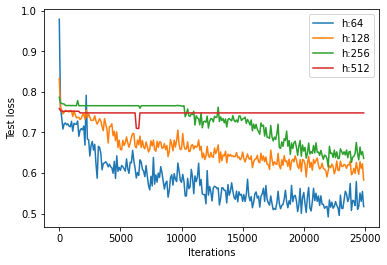

In [16]:
for h, loss in test_loss_dict_hidden.items():
  iter_grid = np.arange(0, 25000, 100)
  plt.plot(iter_grid, loss, label='h:{:d}'.format(h))
plt.legend()
plt.ylabel('Test loss')
plt.xlabel('Iterations')
plt.savefig('prob4_vary_h_loss.png')